<a href="https://www.kaggle.com/code/syerramilli/ps3e23-feature-selection-automl?scriptVersionId=146266696" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

The objective of this classification task is to predict whether a software module has one or more defects based on different measures on code and performance. There are two outcomes - `True` and `False`. Within this notebook, we perform some exploratory data analysis, feature selection, and then use automl via FLAML to train a binary classification model.



In [1]:
# issue with ray version 2.5: https://github.com/microsoft/FLAML/issues/1132
!pip install FLAML "ray[tune]<2.5.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.5.1
    Uninstalling ray-2.5.1:
      Successfully uninstalled ray-2.5.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from flaml import AutoML

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import roc_auc_score, roc_curve


# hierarchical clustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from pathlib import Path

from typing import Optional, List, Dict, Tuple
from numbers import Number

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

## Loading the data

In [3]:
path = Path('/kaggle/input/playground-series-s3e23')

train = pd.read_csv(path / 'train.csv', index_col=['id'])
test = pd.read_csv(path / 'test.csv', index_col=['id'])

train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [4]:
print(f'Number of observations in training set: {train.shape[0]}')
print(f'Number of observations in test set: {test.shape[0]}')

Number of observations in training set: 101763
Number of observations in test set: 67842


Here is a snapshot of the training data. From this, we can see the following:

1. There are 21 potential features, all of which are numerical. 
2. There are no missing values.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  uniq_Op

## Target

The goal of this binary classification task is to predict `defects` - whether or not the software module has one or more defects. The data has some class imbalance.

In [6]:
train['defects'].value_counts() / train.shape[0]

defects
False    0.773356
True     0.226644
Name: count, dtype: float64

## EDA on features

We first check if there is any feature for which its mode has more than 90% of the observations. It is unlikely that any model can reliably use such features. So, we will drop them

In [7]:
def get_mode_fraction(x:pd.Series) -> float:
    cts = x.value_counts(sort=True, ascending=False)
    return cts.iloc[0]/x.shape[0]

def filter_greater_than(series:pd.Series,threshold:Number) -> pd.Series:
    '''
    Returns series elements greater than threshold. This funtion can be
    used with the .pipe methods
    '''
    return series[series>threshold]

high_mode_per = (
    train.drop('defects', axis=1)
    .apply(get_mode_fraction)
    .pipe(filter_greater_than, threshold = 0.8)
)
high_mode_per

locCodeAndComment    0.919293
dtype: float64

In [8]:
# drop these columns
train = train.drop(high_mode_per.index.tolist(), axis=1)

Next, we check if there are any features that are skewed. It turns out all the features are postively skewed, with some being extremely so.

In [9]:
skewness = train.drop('defects', axis=1).skew().sort_values()
skewness

l               1.903337
i               4.859743
d               5.618081
uniq_Op         5.638689
ev(g)           6.513498
branchCount     8.568527
lOBlank         8.717378
n               9.908514
total_Opnd     10.496121
total_Op       11.149996
loc            11.818912
lOComment      12.086854
uniq_Opnd      13.504999
v(g)           14.258631
v              15.959869
lOCode         15.961574
b              16.016099
iv(g)          28.209964
t              46.363403
e              47.676446
dtype: float64

Although correcting the skew isn't needed for tree based models, it helps in visualizing the feature better. Therefore, we will apply a log1p transform to all the features.

In [10]:
numerical_cols= train.select_dtypes(include=['number']).columns.tolist()
train[numerical_cols] = train[numerical_cols].apply(np.log1p)
train = train.rename({col:f'log1p_{col}' for col in numerical_cols}, axis=1)

In the cell below, we plot the histograms of the transformed features. Clearly, some of the features have skewed distributions even after the log1p transformation. It turns out that a lot of features have a large number of 0 values. 

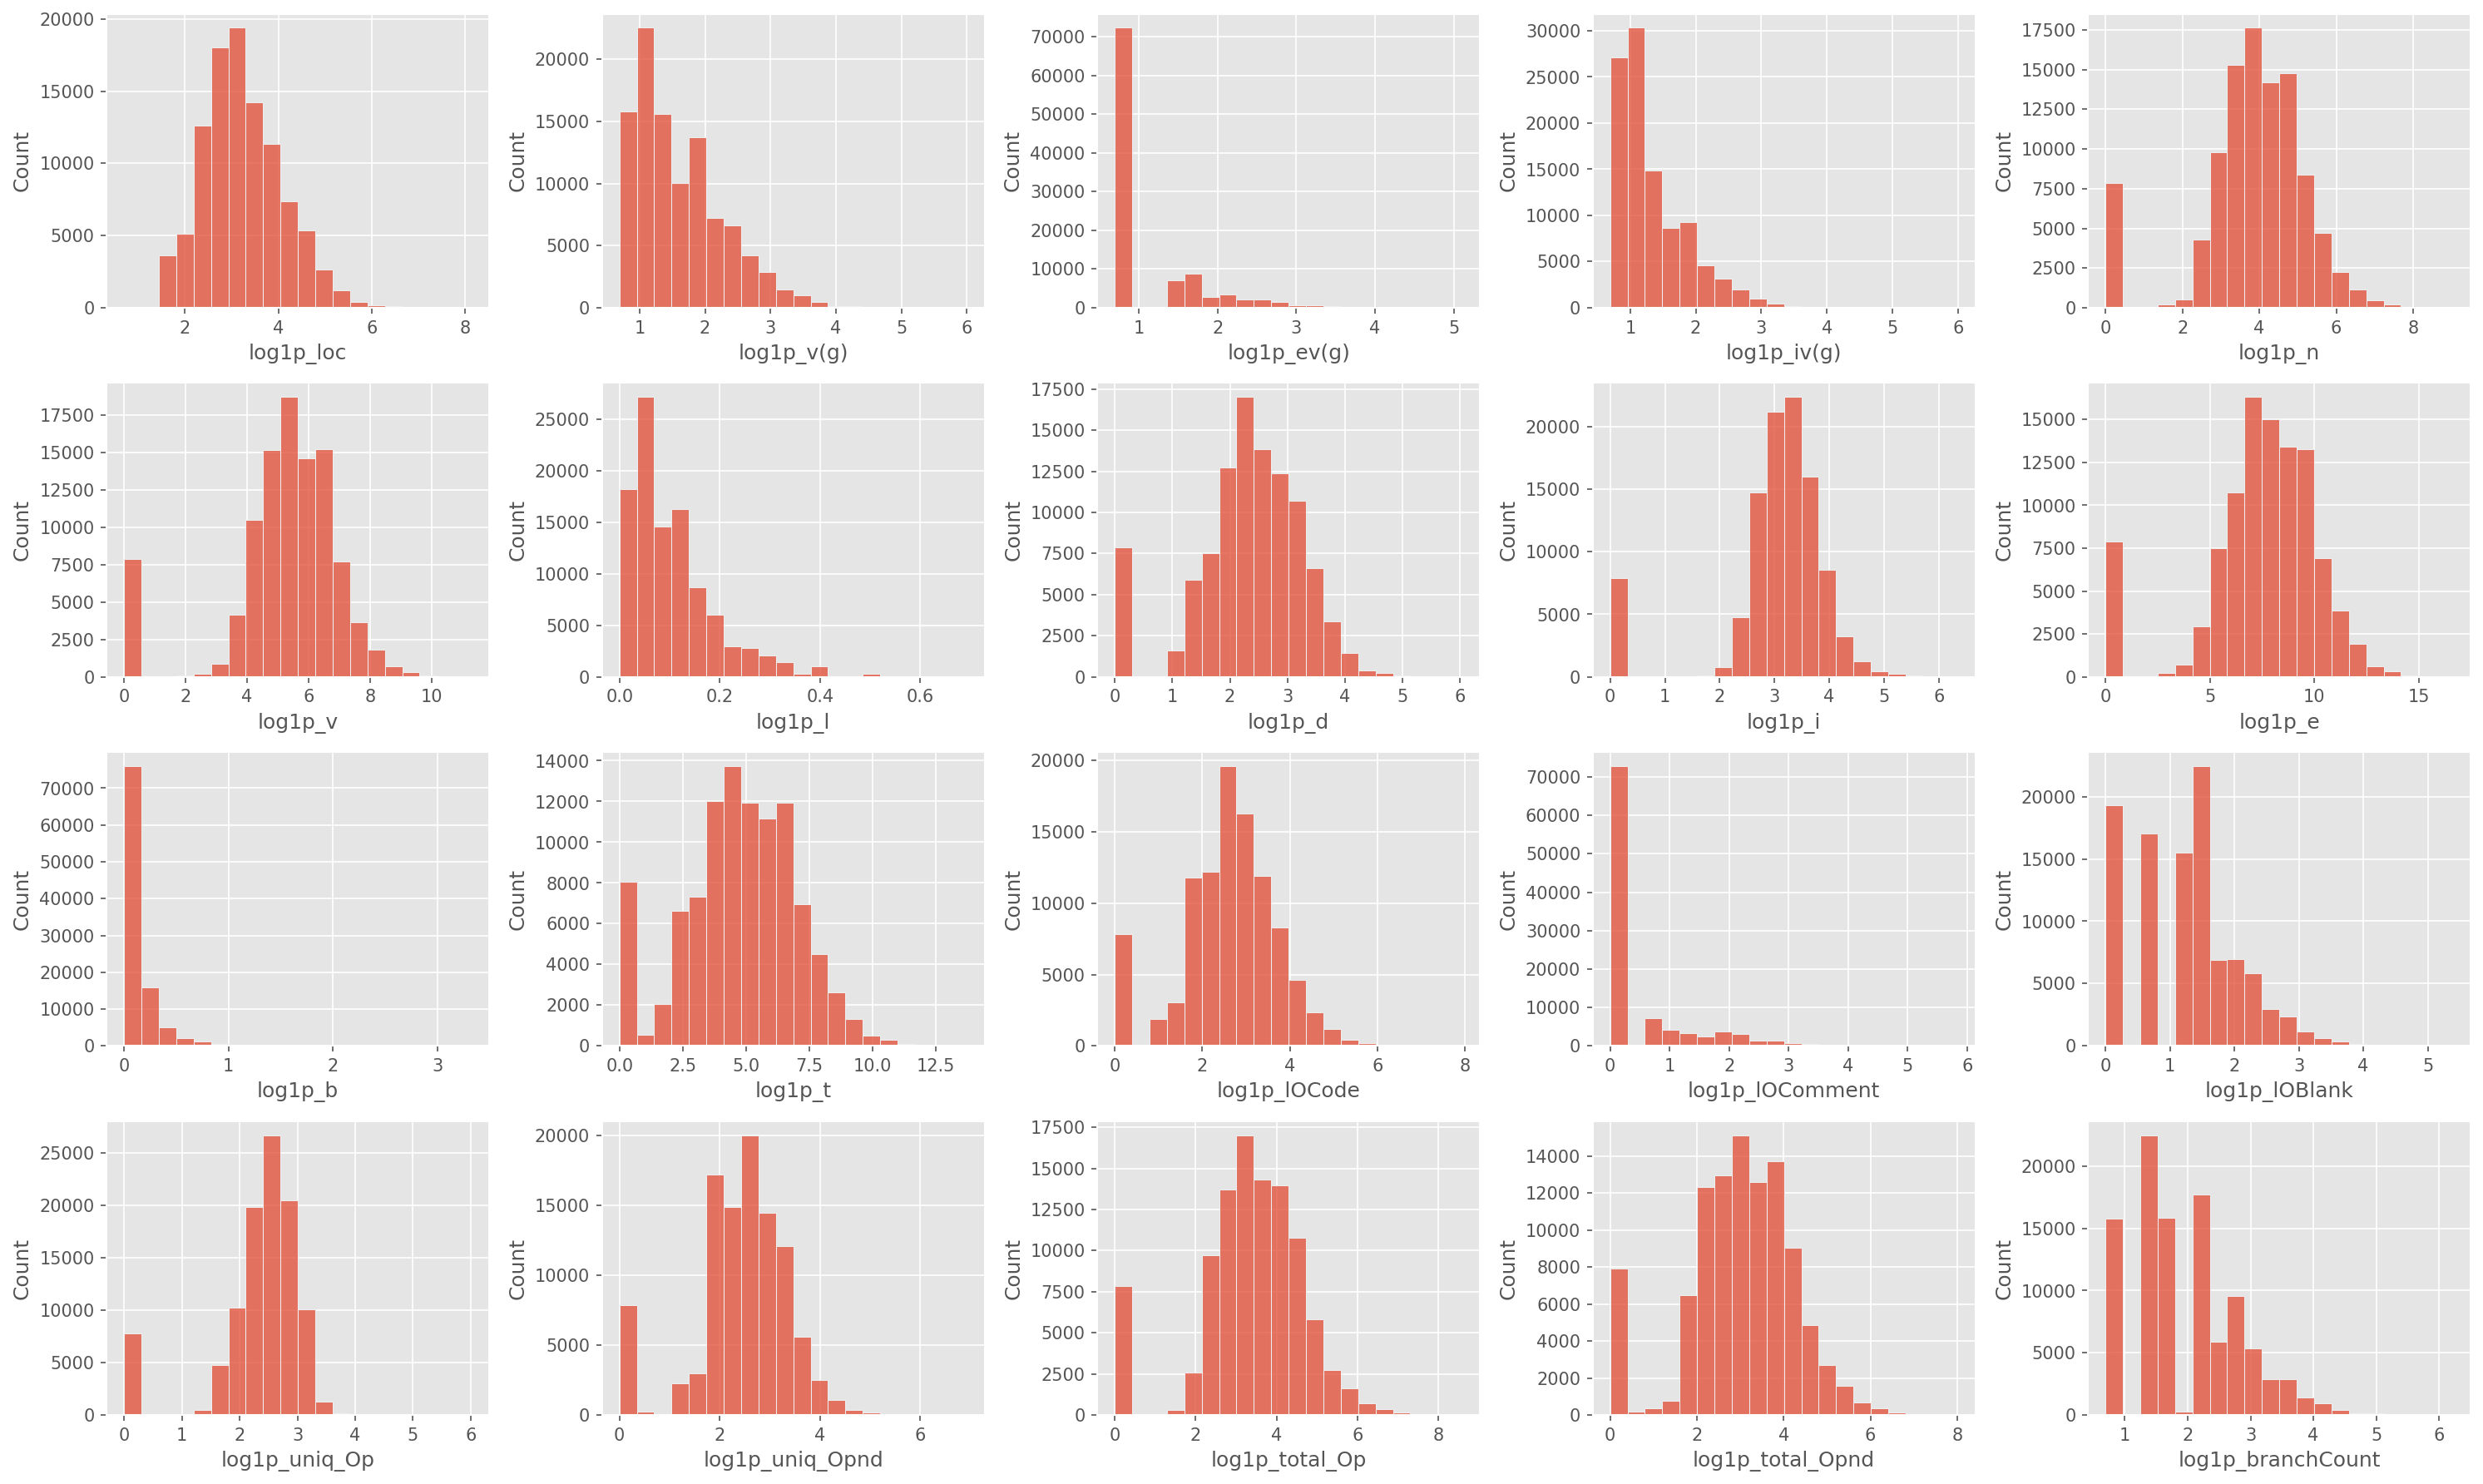

In [11]:
n_rows = 4
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize = (4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        _ = sns.histplot(data=train, x=train.columns[n_cols * i + j], ax=axs[i,j], bins=20)
        
fig.tight_layout()

### Correlation analysis - hierarchical clustering

We now compute the Spearman rank correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as
$$
    \large
    d(x_i,x_j) = 1 - |r(x_i, x_j)|,
$$
where $r(x_i, x_j)$ is the Spearman rank correlation between $x_1$ and $x_2$. The Spearman rank measures the degrees of monotonic dependence between two features. Values closer to +1 or -1 indicate a monotonically increasing or decreasing relationships respectively. So, the dissimilarity between two features will be close to 0 if they are nearly monotonic fuctions of each other. 

In [12]:
# construct correlation matrix
spearman_corr = train.drop('defects', axis=1).corr(method='spearman')

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(spearman_corr.values)

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

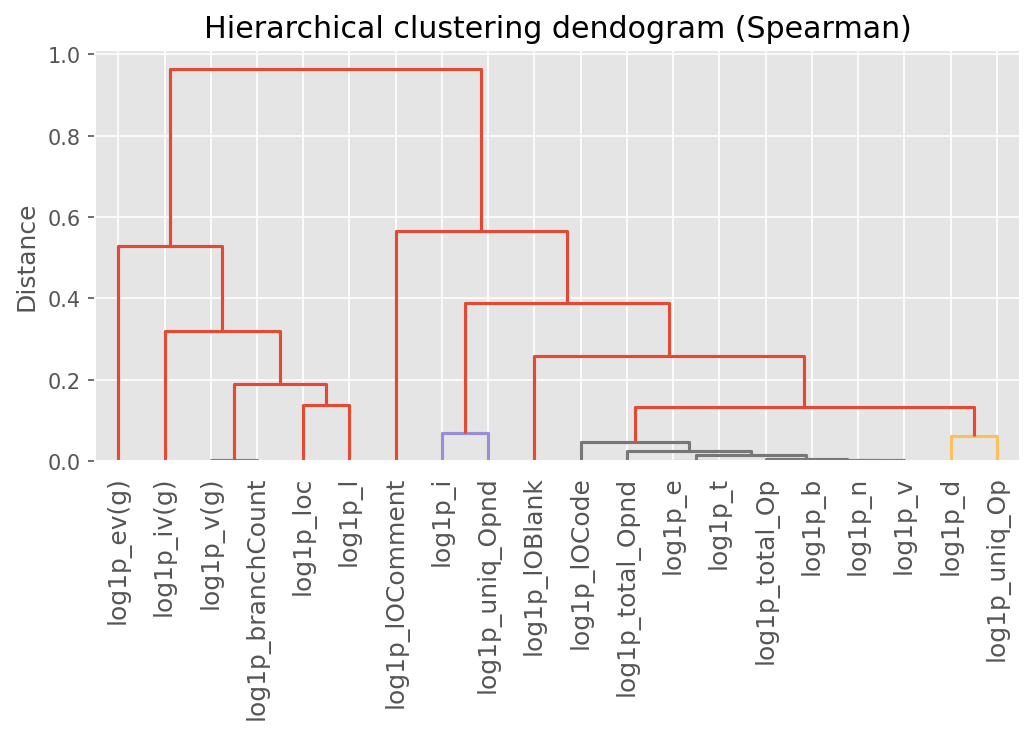

In [13]:
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
    labels=spearman_corr.columns.tolist(),
    color_threshold = 0.1
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram (Spearman)')
fig.tight_layout()

We will now generate the cluster labels for each feature. The number of clusters will depend on the distance we use as a threshold. For smaller distance thresholds, more clusters will be formed. Here, we use a distance threshold of 0.15.

In [14]:
# get the cluster labels
threshold = 0.15
cluster_labels = hierarchy.fcluster(linkage_matrix, threshold, criterion='distance')
n_clusters = np.unique(cluster_labels).shape[0]
print(f'Number of clusters: {n_clusters}\n')

cluster_features = {}

# show features within each cluster
for label in range(1, n_clusters + 1):
    print(f'Cluster {label}')
    
    leaves_in_cluster = cluster_labels == label
    cluster_features[label] = spearman_corr.columns[leaves_in_cluster].tolist()
    print(cluster_features[label])
    print()

Number of clusters: 8

Cluster 1
['log1p_v(g)', 'log1p_branchCount']

Cluster 2
['log1p_loc', 'log1p_l']

Cluster 3
['log1p_iv(g)']

Cluster 4
['log1p_ev(g)']

Cluster 5
['log1p_i', 'log1p_uniq_Opnd']

Cluster 6
['log1p_n', 'log1p_v', 'log1p_d', 'log1p_e', 'log1p_b', 'log1p_t', 'log1p_lOCode', 'log1p_uniq_Op', 'log1p_total_Op', 'log1p_total_Opnd']

Cluster 7
['log1p_lOBlank']

Cluster 8
['log1p_lOComment']



Finally, we will select only one feature from each cluster. 

In [15]:
numerical_features = []
for cols_in_cluster in cluster_features.values():
    numerical_features.append(cols_in_cluster[0])
    
train = train[numerical_features + ['defects']]

### Distributions by class

We now plot the boxplots of the selected features grouped by the different classes. It appears that all the features have different distributions conditioned on the class. However, there are many outliers for each feature within each class. 

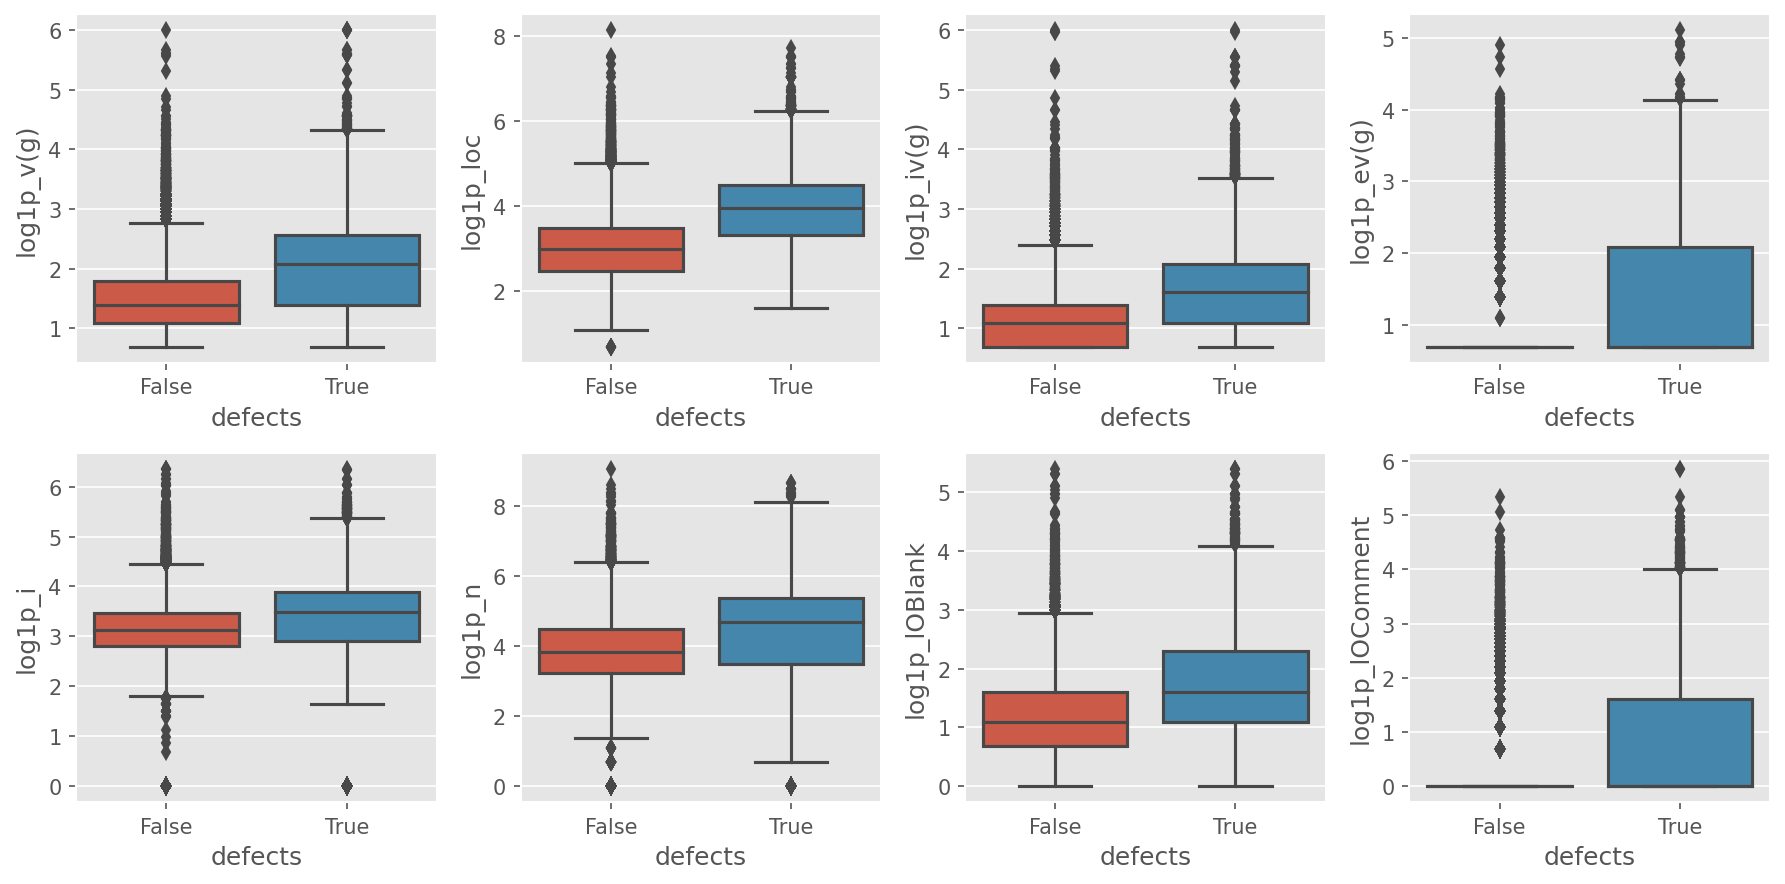

In [16]:
n_rows = 2
n_cols = 4
fig,axs = plt.subplots(n_rows,n_cols,figsize=(3*n_cols,3*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_index = n_cols*i+j
            
        _ = sns.boxplot(data=train, y=numerical_features[col_index], x='defects', ax=axs[i,j])
        
fig.tight_layout()

### Preparing the features

In [17]:
X = train[numerical_features]
y = 1*train['defects'].values

## AutoML via FLaML

FLAML tunes both the type of estimator (e.g., xgboost, random forest, etc.) and the hyperparameters for each estimator simultaneously.


The cell below runs the AutoML algorithm for a total running time of 1500 seconds. This is the `time_budget` key in the the `automl` settings. 

Note: In the automl settings, I pass `"ensemble":True`. This means that the final model will be a stacked ensemble of the best models for each class. Set this to `False` if you only want to use the best model.

In [18]:
import logging
from flaml import logger
logger.setLevel(logging.WARNING)

automl = AutoML()
automl_settings = {
    "time_budget": 1500,  # total running time in seconds (25 minutes)
    "metric": 'roc_auc', 
    "task": 'classification',  # task type
    "estimator_list":['lgbm', 'rf','xgboost', 'extra_tree', 'xgb_limitdepth'],
    "log_file_name": 'defects.log',
    "log_training_metric": True,  # whether to log training metric
    "keep_search_state": True, # needed if you want to keep the cross validation information
    "eval_method": "cv",
    "split_type": "stratified",
    "n_splits": 5,
    "ensemble":True,
    "log_type":'all'
}

_ = automl.fit(X, y, **automl_settings)

[flaml.automl.logger: 10-12 12:55:03] {1679} INFO - task = classification
[flaml.automl.logger: 10-12 12:55:03] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-12 12:55:03] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 10-12 12:55:03] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 10-12 12:55:03] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-12 12:55:04] {2344} INFO - Estimated sufficient time budget=7512s. Estimated necessary time budget=53s.
[flaml.automl.logger: 10-12 12:55:04] {2391} INFO -  at 0.9s,	estimator lgbm's best error=0.2249,	best estimator lgbm's best error=0.2249
[flaml.automl.logger: 10-12 12:55:04] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-12 12:55:05] {2391} INFO -  at 1.7s,	estimator lgbm's best error=0.2249,	best estimator lgbm's best error=0.2249
[flaml.automl.logger: 10-12 12:55:05] {2218

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Here is the best 5-fold CV ROC-AUC for each model class.

In [19]:
# best loss per estimator
(1-pd.Series(automl.best_loss_per_estimator)).sort_values(ascending=False).round(4)

lgbm              0.7911
xgboost           0.7909
extra_tree        0.7907
xgb_limitdepth    0.7906
rf                0.7904
dtype: float64

To get the corresponding configuration for each estimator. use the `.best_config_per_estimator` attribute. (We hide the output of this cell by default).

In [20]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 410,
  'num_leaves': 21,
  'min_child_samples': 58,
  'learning_rate': 0.02945386559911332,
  'log_max_bin': 10,
  'colsample_bytree': 0.7024787820824282,
  'reg_alpha': 0.002585118343615002,
  'reg_lambda': 0.0033864173780056676},
 'rf': {'n_estimators': 48,
  'max_features': 0.6138064234921172,
  'max_leaves': 101,
  'criterion': 'entropy'},
 'xgboost': {'n_estimators': 78,
  'max_leaves': 44,
  'min_child_weight': 8.237247232564762,
  'learning_rate': 0.12911126071039103,
  'subsample': 0.8895588746662894,
  'colsample_bylevel': 0.5768745965984898,
  'colsample_bytree': 0.5915716570022888,
  'reg_alpha': 0.02608844295136239,
  'reg_lambda': 22.48259199821388},
 'extra_tree': {'n_estimators': 90,
  'max_features': 1.0,
  'max_leaves': 262,
  'criterion': 'entropy'},
 'xgb_limitdepth': {'n_estimators': 32,
  'max_depth': 5,
  'min_child_weight': 1.1885317700744058,
  'learning_rate': 0.10997963141009096,
  'subsample': 1.0,
  'colsample_bylevel': 0.8182737361

As mentioned earlier, the final model will be a stacked ensemble of the best models for each class of models. To disable this, and simply select the best performing model, set `"ensemble":False` in `automl_settings`.

In [21]:
automl.model

StackingClassifier(estimators=[('lgbm',
                                <flaml.automl.model.LGBMEstimator object at 0x7adcfd5eab00>),
                               ('xgboost',
                                <flaml.automl.model.XGBoostSklearnEstimator object at 0x7adcfd4bb790>),
                               ('extra_tree',
                                <flaml.automl.model.ExtraTreesEstimator object at 0x7adcfd4b97e0>),
                               ('xgb_limitdepth',
                                <flaml.automl.model.XGBoostLimitDepthEstimator object at 0x7adcfd4bba30>),
                               ('rf',
                                <flaml.automl.model.RandomForestEstimator object at 0x7adcfd4b8580>)],
                   n_jobs=1, passthrough=True)

## Test predictions

In [22]:
# prepare test data
test = test.drop(high_mode_per.index.tolist(), axis=1)

test[numerical_cols] = test[numerical_cols].apply(np.log1p)
test = test.rename({col:f'log1p_{col}' for col in numerical_cols}, axis=1)

test = test[numerical_features]

submission = pd.DataFrame({
    'id':test.index.values,
    'defects': automl.predict_proba(test)[:,1]
})
submission.to_csv('submission.csv',index=False)